In [36]:
from cmath import log,  sqrt, exp, cos
from numpy import full, linspace
from numpy.linalg import solve
from math import floor
from scipy.constants import pi, speed_of_light, epsilon_0, mu_0

In [37]:
a = 1/(2*pi)#raio da antena
b = 5e-4#raio do fio
L = 2*pi*a#comprimento da antena
sigma = 5.8e7#condutividade eletrica do fio
N = 100#numero de segmentos
Delta = L/N#comprimento de cada segmento
lambda_ = 1 # comprimento de onda
k = 2 * pi / lambda_ # número de onda
w = k * speed_of_light # frequência angular (omega)
mi = mu_0 # permeabilidade do meio
epsilon = epsilon_0 # permissividade do meio

Função que retorna a posição $l_n$:

In [38]:
def l(n):
    return n * Delta

Função que retorna a posição $\phi_n$:

In [39]:
def phi(n):
    return l(n)/a

Função que calcula $T(l)$:

In [40]:
def T(l_var):
    if abs(l_var) <= Delta:
        return 1 - (abs(l_var) / Delta)
    else:
        return 0

Função que calcula $W_m(l)$:

In [41]:
def W(l_var, m):
    return T(l_var-l(m))

Função que calcula o valor de $\Psi(m,n)$ dados $m$ e $n$ como argumento:

In [42]:
def Psi(m, n):
    if m == n:
        return (1 / (2 * pi * Delta)) * log(((Delta/2)+sqrt((Delta/2)**2+(b)**2))/ b) - ((k * 1j) / (4 * pi))
    else:
        phi_m = phi(m)
        phi_n = phi(n)
        numerador =  exp(k * sqrt((b**2)+2*(a**2)*(1-cos(phi_m-phi_n))) * -1j)
        denominador = 4 * pi * sqrt((b**2)+2*(a**2)*(1-cos(phi_m-phi_n)))
        return numerador / denominador

Função que calcula o valor de $\Phi_{mn}$ dados $m$ e $n$ como argumento:

In [43]:
def Phi(m, n):
    return Psi(m - 0.5, n - 0.5) - Psi(m - 0.5, n + 0.5) - Psi(m + 0.5, n - 0.5) + Psi(m + 0.5, n + 0.5)

Função que calcula o valor de $A_{mn}$ dados $m$ e $n$ como argumento:

In [44]:
def A(m, n):
    return cos(phi(m)-phi(n)) * Delta * Delta * Psi(m, n)

Função que calcula o valor de $Z_{mn}$ dados $m$ e $n$ como argumento:

In [45]:
def Z_mn(m, n):
    return (w * mi * A(m, n) * -1j) - (Phi(m, n) / (1j*w*epsilon))

Função que gera a matriz $[Z]$:

In [ ]:
def Z():
    matriz = full([N, N], 0j)
    for i in range(N):
        for j in range(N):
            matriz[i][j] = Z_mn(i, j)
    return matriz

Função que gera a matriz $[V]$:

In [47]:
def V():
    matriz = full([N, 1], 0j)
    matriz[N-1] = -W(0, 0)
    return matriz

Função que resolve o sistema linear:

In [48]:
def sistema_linear():
    matriz_Z = Z()
    matriz_V = V()
    corrente = solve(matriz_Z, matriz_V)
    impedancia = 1 / corrente[N-1]
    return corrente, impedancia

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
lista_impedancia_real=[]
lista_impedancia_imag=[]
correntes_por_N = {}
for i in range(400, 800):
  N  = i
  Delta = L/N
  corrente, impedancia = sistema_linear()
  correntes_por_N[N] = corrente
  lista_impedancia_real.append(impedancia.real)
  lista_impedancia_imag.append(impedancia.imag)

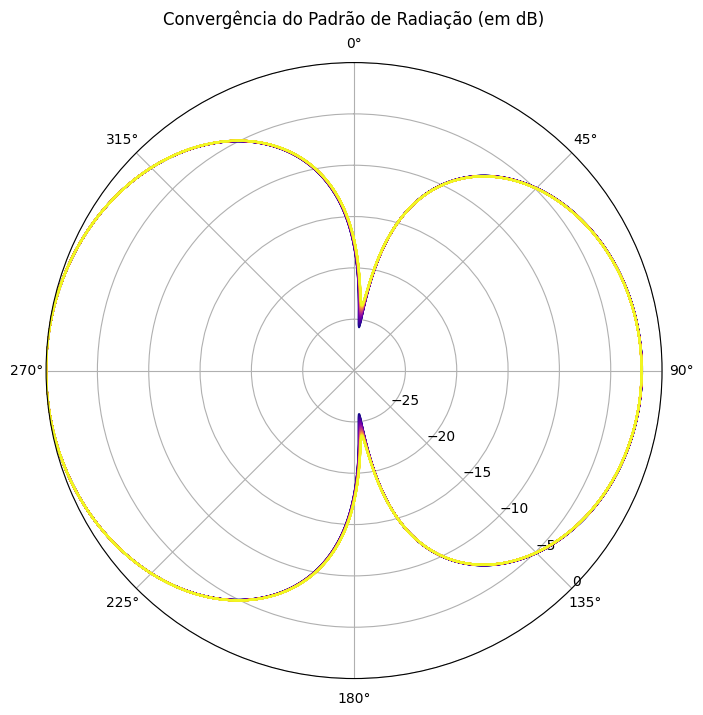

In [ ]:
thetas = np.linspace(0, 2*np.pi, 720)

padroes_por_N = {}

for N, corrente in correntes_por_N.items():
    phi_vals = np.linspace(0, 2*np.pi, N, endpoint=False)
    Delta_phi = 2*np.pi / N
    E_theta = []

    for theta in thetas:
        soma = 0j
        for n in range(N):
            soma += corrente[n] * np.exp(1j * k * a * np.sin(theta) * np.cos(phi_vals[n])) * Delta_phi
        E_theta.append(soma)

    E_theta = np.array(E_theta)
    U_theta = np.abs(E_theta)**2
    U_theta /= np.max(U_theta)
    U_dB = 10 * np.log10(U_theta + 1e-20)
    padroes_por_N[N] = U_dB


plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

cores = plt.cm.plasma(np.linspace(0, 1, len(padroes_por_N)))

for (N, U_dB), cor in zip(padroes_por_N.items(), cores):
    ax.plot(thetas, U_dB, color=cor, linewidth=1.5)

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Convergência do Padrão de Radiação (em dB)', va='bottom')
ax.set_rlim(-30, 0)
ax.set_rlabel_position(135)
plt.show()


Plotando a convergência da impedância:

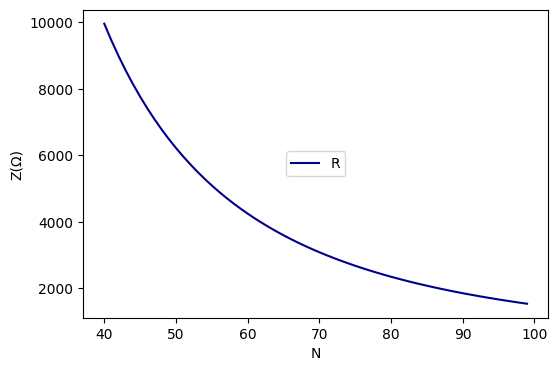

In [ ]:
N1 = range(400, 800)
plt.figure(figsize=(6, 4))
plt.plot(N1, lista_impedancia_real, color='darkblue', label="R")
plt.xlabel("N")
plt.ylabel("Z(\u03A9)")
plt.legend(loc='center')
plt.show()

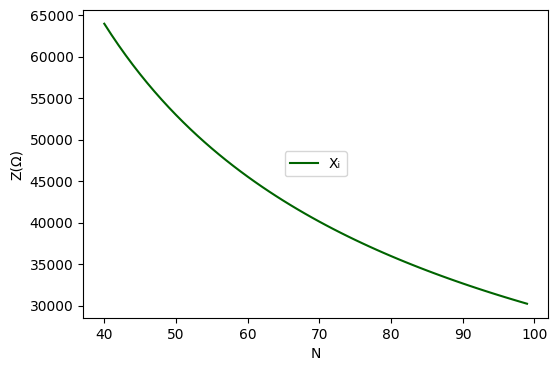

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(N1, lista_impedancia_imag, color='darkgreen', label="X\u1D62")
plt.xlabel("N")
plt.ylabel("Z(\u03A9)")
plt.legend(loc='center')
plt.show()